In [39]:
from PIL import Image, ImageEnhance, ImageFilter

import matplotlib.pyplot as plt

import cv2
import numpy as np

In [53]:
def show_img(image, gray=None):
    plt.imshow(image, cmap=gray)
    plt.axis('off')

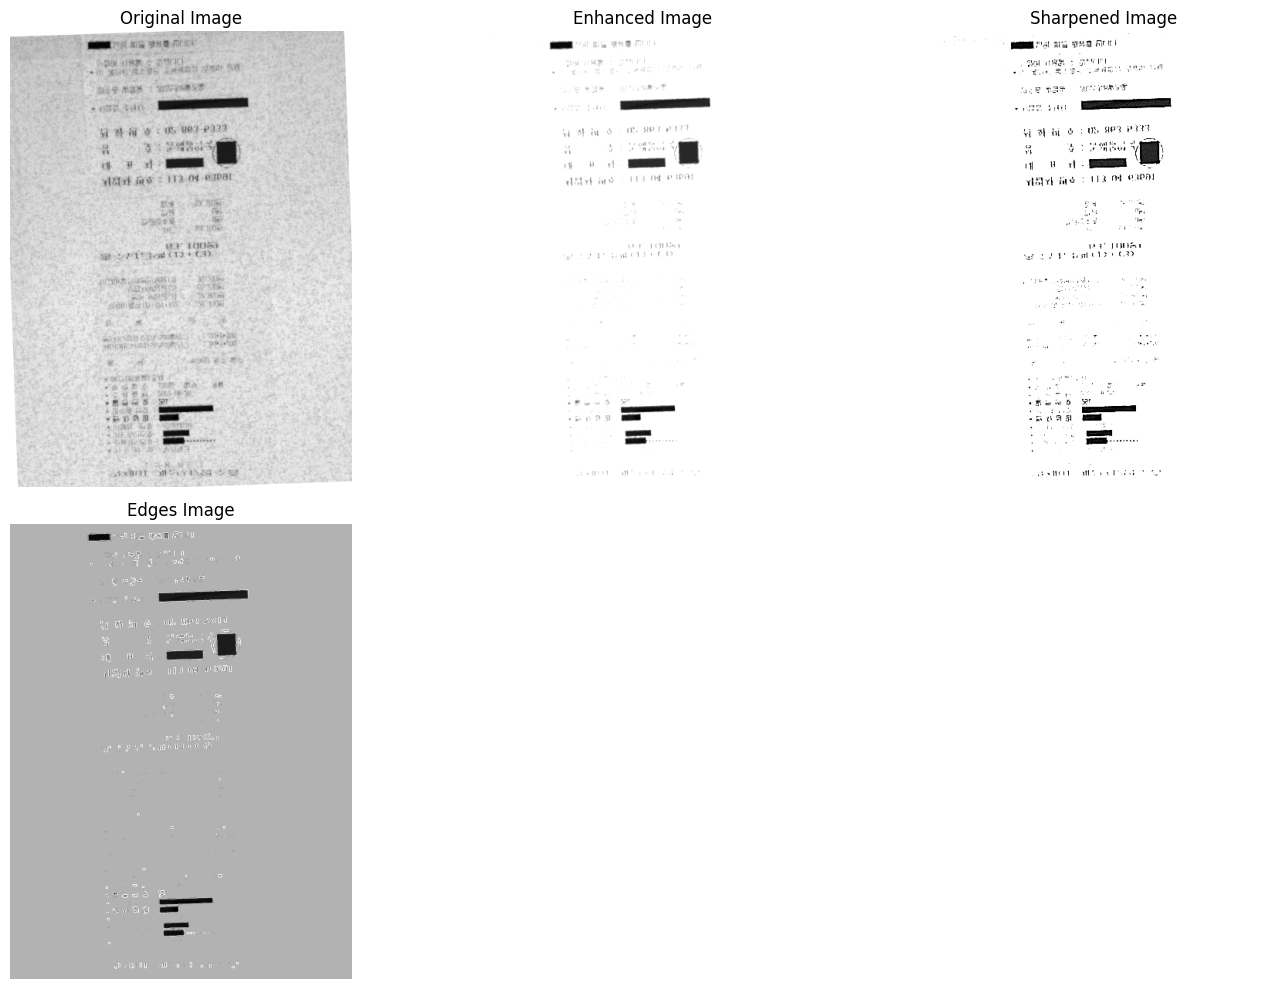

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기 및 그레이스케일로 변환
img_path = '/upstage-cv-classification-cv2/data/test/1a4ccaed60d695eb.jpg'
original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 대비 향상
alpha = 1.5  # Contrast control (1.0-3.0)
beta = 0     # Brightness control (0-100)
enhanced_img = cv2.convertScaleAbs(original_image, alpha=alpha, beta=beta)

# 샤프닝
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
sharpened_image = cv2.filter2D(enhanced_img, -1, sharpening_kernel)

# Canny 엣지 디텍션 적용
edges = cv2.Canny(enhanced_img, 100, 200)
edges_image = cv2.addWeighted(enhanced_img, 0.7, edges, 0.3, 0)



In [60]:
import cv2
import numpy as np
from skimage import io
from skimage.filters import threshold_local
from skimage.transform import rotate

def scan_and_process_document(image_path):
    # 1. 이미지 로드
    image = cv2.imread(image_path)
    
    # 2. 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 3. 노이즈 제거
    denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
    
    # 4. 이진화
    T = threshold_local(denoised, 11, offset=10, method="gaussian")
    binary = (denoised > T).astype("uint8") * 255
    
    # 5. 스큐(기울기) 보정
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # 6. 테두리 제거
    contours, _ = cv2.findContours(rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        cropped = rotated[y:y+h, x:x+w]
    else:
        cropped = rotated
    
    return cropped

processed_image = scan_and_process_document(img_path)

# 샤프닝
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  18, -1],
                              [-1, -1, -1]])
processed_sharpened_image = cv2.filter2D(processed_image, -1, sharpening_kernel)



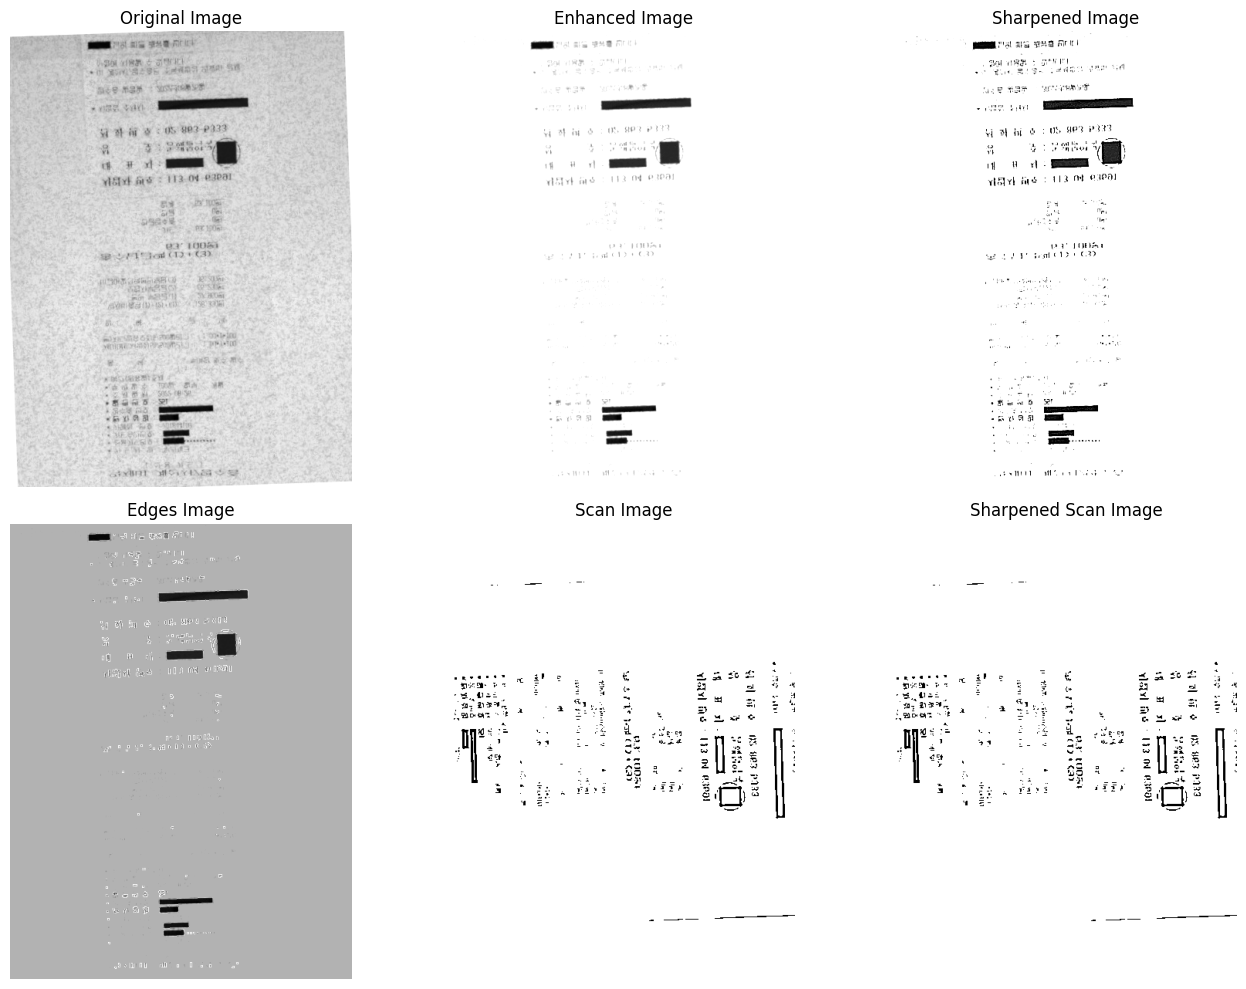

In [61]:
# 결과 표시
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image')
show_img(original_image, 'gray')

plt.subplot(2, 3, 2)
plt.title('Enhanced Image')
show_img(enhanced_img, 'gray')

plt.subplot(2, 3, 3)
plt.title('Sharpened Image')
show_img(sharpened_image, 'gray')

plt.subplot(2, 3, 4)
plt.title('Edges Image')
show_img(edges_image, 'gray')

plt.subplot(2, 3, 5)
plt.title('Scan Image')
show_img(processed_image, 'gray')

plt.subplot(2, 3, 6)
plt.title('Sharpened Scan Image')
show_img(processed_sharpened_image, 'gray')

plt.tight_layout()
plt.show()